#### Libraries

In [1]:
%%javascript
utils.load_extension("collapsible_headings/main")

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import random
random.seed(0)

pd.set_option("display.max_columns", None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pdb

%matplotlib inline
from matplotlib import rcParams

plt.style.use("seaborn-whitegrid")
rcParams["axes.labelsize"] = 14
rcParams["xtick.labelsize"] = 12
rcParams["ytick.labelsize"] = 12
rcParams["figure.figsize"] = 16, 8

# from pandas_profiling import ProfileReportofileReport

import warnings

warnings.filterwarnings("ignore")

In [3]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [10, 5]

In [4]:
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import (
    selection_rate,
    false_positive_rate,
    true_positive_rate,
    count,
)
import shap

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBRegressor, XGBClassifier
from catboost import CatBoostClassifier
import shap

from category_encoders.target_encoder import TargetEncoder
from category_encoders.m_estimate import MEstimateEncoder
from category_encoders.cat_boost import CatBoostEncoder
from category_encoders.leave_one_out import LeaveOneOutEncoder
from category_encoders.woe import WOEEncoder
from category_encoders.james_stein import JamesSteinEncoder

from tqdm.notebook import tqdm
from collections import defaultdict

In [5]:
from category_encoders import OneHotEncoder

## Data Loading and helper functions

In [6]:
df = pd.read_csv("data/compas-scores-raw.csv")

In [7]:
df = pd.read_csv("data/compas-scores-raw.csv")

df["Score"] = df["DecileScore"]

# df.loc[df["DecileScore"] > 7, "Score"] = 2
# df.loc[(df["DecileScore"] > 4) & (df["DecileScore"] < 8), "Score"] = 1
# df.loc[df["DecileScore"] < 5, "Score"] = 0

df.loc[df["DecileScore"] > 4, "Score"] = 1
df.loc[df["DecileScore"] <= 4, "Score"] = 0


cols = [
    "Person_ID",
    "AssessmentID",
    "Case_ID",
    "LastName",
    "FirstName",
    "MiddleName",
    "DateOfBirth",
    "ScaleSet_ID",
    "Screening_Date",
    "RecSupervisionLevel",
    #"Agency_Text",
    #"AssessmentReason",
    "Language",
    "Scale_ID",
    #"IsCompleted",
    #"IsDeleted",
    #"AssessmentType",
    "DecileScore",
    "RecSupervisionLevelText",
    #"DisplayText",
    #"ScaleSet",
    #"LegalStatus",
    #"CustodyStatus",

]


df = df.drop(columns=cols)

possible_targets = ["RawScore", "ScoreText", "Score"]

X = df.drop(columns=possible_targets)
y = df[["Score"]]

In [8]:
X['Sex_Code_Text'] = pd.get_dummies(X['Sex_Code_Text'],prefix='Sex')['Sex_Male']
X["ScaleSet"] = pd.get_dummies(X['ScaleSet'])['Risk and Prescreen']

In [9]:
X["EthnicMarital"] = X["Ethnic_Code_Text"] + X["MaritalStatus"]
X = X.drop(columns=["Ethnic_Code_Text", "MaritalStatus"])

In [10]:
X[['Sex_Code_Text', 'ScaleSet', 'IsCompleted', 'IsDeleted']].astype(object)

,Sex_Code_Text,ScaleSet,IsCompleted,IsDeleted
0,1,1,1,0
1,1,1,1,0
2,1,1,1,0
3,1,1,1,0
4,1,1,1,0
...,...,...,...,...
60838,1,1,1,0
60839,1,1,1,0
60840,1,1,1,0
60841,1,1,1,0


In [11]:
X.columns

Index(['Agency_Text', 'Sex_Code_Text', 'ScaleSet', 'AssessmentReason',
       'LegalStatus', 'CustodyStatus', 'DisplayText', 'AssessmentType',
       'IsCompleted', 'IsDeleted', 'EthnicMarital'],
      dtype='object')

In [12]:
for col in X.columns:
    print(X[col].value_counts())

PRETRIAL          41100
Probation         19056
DRRD                564
Broward County      123
Name: Agency_Text, dtype: int64
1    47514
0    13329
Name: Sex_Code_Text, dtype: int64
1    58647
0     2196
Name: ScaleSet, dtype: int64
Intake    60843
Name: AssessmentReason, dtype: int64
Pretrial               37578
Post Sentence          18333
Other                   4356
Conditional Release      420
Probation Violator       126
Parole Violator           18
Deferred Sentencing       12
Name: LegalStatus, dtype: int64
Jail Inmate            30129
Probation              22968
Pretrial Defendant      7644
Residential Program       66
Parole                    21
Prison Inmate             15
Name: CustodyStatus, dtype: int64
Risk of Violence             20281
Risk of Recidivism           20281
Risk of Failure to Appear    20281
Name: DisplayText, dtype: int64
New     56139
Copy     4704
Name: AssessmentType, dtype: int64
1    60843
Name: IsCompleted, dtype: int64
0    60843
Name: IsDeleted

In [13]:
for col in X.columns:
    print(len(X[col].unique()))

4
2
2
1
7
6
3
2
1
1
46


In [14]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.75, random_state=42)

In [15]:
aux = X_te.copy()
aux['t'] = y_te['Score'].values

In [16]:
aux[aux['EthnicMarital']=='AsianSingle'].t.value_counts()

0    96
1    25
Name: t, dtype: int64

In [17]:
def fit_predict(modelo, enc, data, target, test):
    pipe = Pipeline([("encoder", enc), ("model", modelo)])
    pipe.fit(data, target)
    return pipe.predict(test)


def auc_group(model, data, y_true, dicc, group: str = "", min_samples: int = 50):

    aux = data.copy()
    aux["target"] = y_true
    cats = aux[group].value_counts()
    cats = cats[cats > min_samples].index.tolist()
    cats = cats + ["all"]

    if len(dicc) == 0:
        dicc = defaultdict(list, {k: [] for k in cats})

    for cat in cats:
        if cat != "all":
            aux2 = aux[aux[group] == cat]
            preds = model.predict_proba(aux2.drop(columns="target"))[:, 1]
            truth = aux2["target"]
            dicc[cat].append(roc_auc_score(truth, preds))
        elif cat == "all":
            dicc[cat].append(roc_auc_score(y_true, model.predict_proba(data)[:, 1]))
        else:
            pass

    return dicc

In [18]:
def explain(xgb: bool = True):
    """
    Provide a SHAP explanation by fitting MEstimate and GBDT
    """
    if xgb:
        pipe = Pipeline(
            [("encoder", MEstimateEncoder()), ("model", GradientBoostingClassifier())]
        )
        pipe.fit(X_tr, y_tr)
        explainer = shap.Explainer(pipe[1])
        shap_values = explainer(pipe[:-1].transform(X_tr))
        shap.plots.beeswarm(shap_values)
        return pd.DataFrame(np.abs(shap_values.values), columns=X_tr.columns).sum()
    else:
        pipe = Pipeline(
            [("encoder", MEstimateEncoder()), ("model", LogisticRegression())]
        )
        pipe.fit(X_tr, y_tr)
        coefficients = pd.concat(
            [pd.DataFrame(X_tr.columns), pd.DataFrame(np.transpose(pipe[1].coef_))],
            axis=1,
        )
        coefficients.columns = ["feat", "val"]

        return coefficients.sort_values(by="val", ascending=False)

In [19]:
def calculate_cm(true, preds):
    # Obtain the confusion matrix
    cm = confusion_matrix(preds, true)

    #  https://stackoverflow.com/questions/31324218/scikit-learn-how-to-obtain-true-positive-true-negative-false-positive-and-fal
    FP = cm.sum(axis=0) - np.diag(cm)
    FN = cm.sum(axis=1) - np.diag(cm)
    TP = np.diag(cm)
    TN = cm.sum() - (FP + FN + TP)

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP / (TP + FN)
    # Specificity or true negative rate
    TNR = TN / (TN + FP)
    # Precision or positive predictive value
    PPV = TP / (TP + FP)
    # Negative predictive value
    NPV = TN / (TN + FN)
    # Fall out or false positive rate
    FPR = FP / (FP + TN)
    # False negative rate
    FNR = FN / (TP + FN)
    # False discovery rate
    FDR = FP / (TP + FP)

    # Overall accuracy
    ACC = (TP + TN) / (TP + FP + FN + TN)

    ##########
    ## I AM NOT SURE ABOUT THIS 0 INDEX
    ###########
    return TPR[0]

In [20]:
def metric_calculator(
    modelo, data: pd.DataFrame, truth: pd.DataFrame, col: str, group1: str, group2: str
):
    aux = data.copy()
    aux["target"] = truth

    # Filter the data
    g1 = data[data[col] == group1]
    g2 = data[data[col] == group2]

    # Filter the ground truth
    g1_true = aux[aux[col] == group1].target
    g2_true = aux[aux[col] == group2].target

    # Do predictions
    p1 = modelo.predict(g1)
    p2 = modelo.predict(g2)

    # Extract metrics for each group
    res1 = calculate_cm(p1, g1_true)
    res2 = calculate_cm(p2, g2_true)
    return res1 - res2

In [21]:
m = Pipeline([('enc',OneHotEncoder()),('model',LogisticRegression())])
m.fit(X,y)

Pipeline(steps=[('enc',
                 OneHotEncoder(cols=['Agency_Text', 'AssessmentReason',
                                     'LegalStatus', 'CustodyStatus',
                                     'DisplayText', 'AssessmentType',
                                     'EthnicMarital'])),
                ('model', LogisticRegression())])

In [22]:
res = {}
for cat,num in X['EthnicMarital'].value_counts().items():
    COL = "EthnicMarital"
    GROUP1 = "African-AmericanSingle"
    GROUP2 = cat
    res[cat] = [metric_calculator(modelo=m,data = X, truth = y,col=COL,group1=GROUP1,group2 =GROUP2),num]
    

In [23]:
res = pd.DataFrame(res).T

res.columns=['fairness','items']

res['items']= res['items'].astype(int)

In [24]:
res

,fairness,items
African-AmericanSingle,0.000000,22416
CaucasianSingle,-0.258650,15198
HispanicSingle,-0.270283,5514
CaucasianMarried,-0.279380,3012
African-AmericanMarried,-0.271112,2535
CaucasianDivorced,-0.278346,2280
HispanicMarried,-0.279380,1776
OtherSingle,-0.278538,1551
HispanicDivorced,-0.279380,825
OtherMarried,-0.279380,696


In [25]:
def plot_rolling(data, roll_mean: int = 5, roll_std: int = 20):

    aux = data.rolling(roll_mean).mean().dropna()
    stand = data.rolling(roll_std).quantile(0.05, interpolation="lower").dropna()
    plt.figure()
    for col in data.columns:
        plt.plot(aux[col], label=col)
        # plt.fill_between(aux.index,(aux[col] - stand[col]),(aux[col] + stand[col]),# color="b",alpha=0.1,)
    plt.legend()
    plt.show()

In [26]:
def scale_output(data):
    return pd.DataFrame(
        StandardScaler().fit_transform(data), columns=data.columns, index=data.index
    )

# Experiment

In [27]:
def fair_encoder(model, param: list, enc: str = "mestimate", un_regularize: list = []):
    auc = {}
    metrica = []
    auc_tot = []

    allowed_enc = [
        "mestimate",
        "targetenc",
        "leaveoneout",
        "ohe",
        "woe",
        "james",
        "catboost",
    ]
    assert (
        enc in allowed_enc
    ), "Encoder not available or check for spelling mistakes: {}".format(allowed_enc)

    cols_enc = set(X_tr.columns) - set(un_regularize)

    for m in tqdm(param):
        if enc == "mestimate":
            encoder = Pipeline(
                [
                    ("reg", MEstimateEncoder(m=m, cols=cols_enc)),
                    ("unreg", MEstimateEncoder(m=0, cols=un_regularize)),
                ]
            )
        elif enc == "targetenc":
            encoder = TargetEncoder(smoothing=m)
        elif enc == "leaveoneout":
            encoder = Pipeline(
                [
                    ("reg", LeaveOneOutEncoder(sigma=m, cols=cols_enc)),
                    ("unreg", LeaveOneOutEncoder(sigma=0, cols=un_regularize)),
                ]
            )
        elif enc == "ohe":
            encoder = OneHotEncoder(handle_missing=-1)
        elif enc == "woe":
            encoder = WOEEncoder(randomized=True, sigma=m)
        elif enc == "james":
            encoder = JamesSteinEncoder(randomized=True, sigma=m)
        elif enc == "catboost":
            encoder = Pipeline(
                [
                    ("reg", CatBoostEncoder(a=1, sigma=m, cols=cols_enc)),
                    ("unreg", CatBoostEncoder(a=1, sigma=0, cols=un_regularize)),
                ]
            ) 

        pipe = Pipeline([("encoder", encoder), ("model", model)])
        pipe.fit(X_tr, y_tr)
        if m==1:
            print(pipe)
        preds = pipe.predict(X_te)

        metrica.append(
            metric_calculator(
                modelo=pipe,
                data=X_tr,
                truth=y_tr,
                col=COL,
                group1=GROUP1,
                group2=GROUP2,
            )
        )
        auc = auc_group(model=pipe, data=X_te, y_true=y_te, dicc=auc, group=COL)
        auc_tot.append(roc_auc_score(y_te, pipe.predict_proba(X_te)[:, 1]))

    # Results formatting
    res = pd.DataFrame(index=param)
    res["fairness_metric"] = metrica
    res["auc_tot"] = auc_tot
    res["auc_" + GROUP1] = auc[GROUP1]
    res["auc_" + GROUP2] = auc[GROUP2]

    return res

In [28]:
# Experiment parameters
COL = "EthnicMarital"
GROUP1 = "African-AmericanSingle"
GROUP2 = "CaucasianMarried"
PARAM = np.linspace(0, 1, 50)

# Plot parametes
XMIN = 0.55
XMAX = 0.725
YMIN = -0.5
YMAX = 0

In [29]:
one_hot = fair_encoder(model=LogisticRegression(), enc="ohe", param=[0])

PARAM = np.linspace(0, 1, 50)
gaus = fair_encoder(model=LogisticRegression(), enc="catboost", param=PARAM,un_regularize=['Agency_Text', 'Sex_Code_Text', 'ScaleSet', 'AssessmentReason',
       'LegalStatus', 'CustodyStatus', 'DisplayText', 'AssessmentType',
       'IsCompleted', 'IsDeleted'])
PARAM = np.linspace(0, 100, 50)
smooth = fair_encoder(model=LogisticRegression(), enc="mestimate", param=PARAM,un_regularize=['Agency_Text', 'Sex_Code_Text', 'ScaleSet', 'AssessmentReason',
       'LegalStatus', 'CustodyStatus', 'DisplayText', 'AssessmentType',
       'IsCompleted', 'IsDeleted'])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Pipeline(steps=[('encoder',
                 Pipeline(steps=[('reg',
                                  CatBoostEncoder(cols=['EthnicMarital'],
                                                  sigma=1.0)),
                                 ('unreg',
                                  CatBoostEncoder(cols=['Agency_Text',
                                                        'Sex_Code_Text',
                                                        'ScaleSet',
                                                        'AssessmentReason',
                                                        'LegalStatus',
                                                        'CustodyStatus',
                                                        'DisplayText',
                                                        'AssessmentType',
                                                        'IsCompleted',
                                                        'IsDeleted'],
                                 

  0%|          | 0/50 [00:00<?, ?it/s]

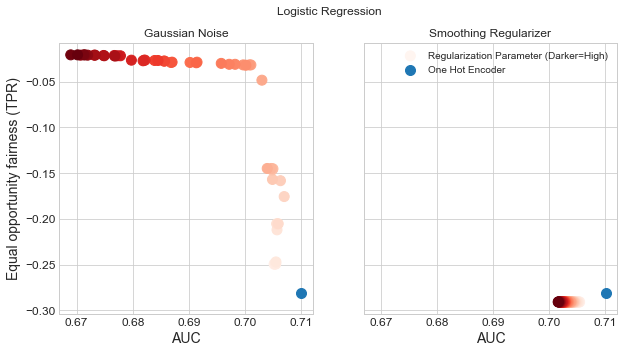

In [30]:

fig, (ax1, ax2) = plt.subplots(1, 2,sharex=True,sharey=True)
fig.suptitle('Logistic Regression')
#for ax in (ax1, ax2):
#    ax.set_xlim([XMIN, XMAX])
#    ax.set_ylim([YMIN, YMAX])
    
ax1.set_title('Gaussian Noise')
ax1.set(xlabel='AUC', ylabel='Equal opportunity fairness (TPR)')
ax1.scatter(
    gaus["auc_tot"].values,
    gaus["fairness_metric"].values,
    s=100,
    c=gaus.index.values,
    cmap="Reds",
    label="Regularization Parameter (Darker=High)"
)
ax1.scatter(
    y=one_hot.fairness_metric, x=one_hot.auc_tot, s=100, label="One Hot Encoder"
)

ax2.set_title('Smoothing Regularizer')
ax2.set(xlabel='AUC')
ax2.scatter(
    smooth["auc_tot"].values,
    smooth["fairness_metric"].values,
    s=100,
    c=smooth.index.values,
    cmap="Reds",
    label="Regularization Parameter (Darker=High)",
)
ax2.scatter(
    y=one_hot.fairness_metric, x=one_hot.auc_tot, s=100, label="One Hot Encoder"
)
ax2.legend()
plt.savefig('images/logisticEnc.eps',format='eps')
fig.show()

In [31]:
one_hot = fair_encoder(model=DecisionTreeClassifier(max_depth=5), enc="ohe", param=[0])

PARAM = np.linspace(0, 1, 50)
gaus = fair_encoder(model=DecisionTreeClassifier(max_depth=5), enc="catboost", param=PARAM,un_regularize=['Agency_Text', 'Sex_Code_Text', 'ScaleSet', 'AssessmentReason',
       'LegalStatus', 'CustodyStatus', 'DisplayText', 'AssessmentType',
       'IsCompleted', 'IsDeleted'])
PARAM = np.linspace(0, 100, 50)
smooth = fair_encoder(model=DecisionTreeClassifier(max_depth=5), enc="mestimate", param=PARAM,un_regularize=['Agency_Text', 'Sex_Code_Text', 'ScaleSet', 'AssessmentReason',
       'LegalStatus', 'CustodyStatus', 'DisplayText', 'AssessmentType',
       'IsCompleted', 'IsDeleted'])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Pipeline(steps=[('encoder',
                 Pipeline(steps=[('reg',
                                  CatBoostEncoder(cols=['EthnicMarital'],
                                                  sigma=1.0)),
                                 ('unreg',
                                  CatBoostEncoder(cols=['Agency_Text',
                                                        'Sex_Code_Text',
                                                        'ScaleSet',
                                                        'AssessmentReason',
                                                        'LegalStatus',
                                                        'CustodyStatus',
                                                        'DisplayText',
                                                        'AssessmentType',
                                                        'IsCompleted',
                                                        'IsDeleted'],
                                 

  0%|          | 0/50 [00:00<?, ?it/s]

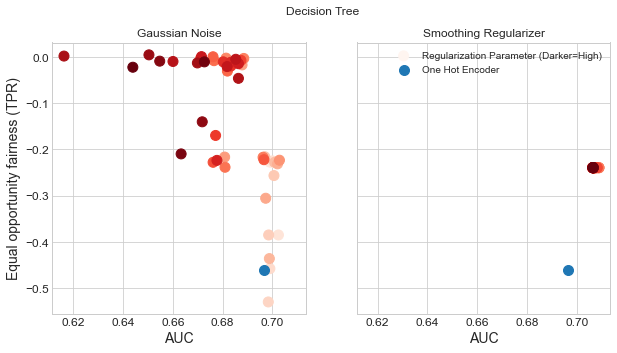

In [32]:

fig, (ax1, ax2) = plt.subplots(1, 2,sharex=True,sharey=True)
fig.suptitle('Decision Tree')
#for ax in (ax1, ax2):
#    ax.set_xlim([XMIN, XMAX])
#    ax.set_ylim([YMIN, YMAX])
    
ax1.set_title('Gaussian Noise')
ax1.set(xlabel='AUC', ylabel='Equal opportunity fairness (TPR)')
ax1.scatter(
    gaus["auc_tot"].values,
    gaus["fairness_metric"].values,
    s=100,
    c=gaus.index.values,
    cmap="Reds",
    label="Regularization Parameter (Darker=High)"
)
ax1.scatter(
    y=one_hot.fairness_metric, x=one_hot.auc_tot, s=100, label="One Hot Encoder"
)

ax2.set_title('Smoothing Regularizer')
ax2.set(xlabel='AUC')
ax2.scatter(
    smooth["auc_tot"].values,
    smooth["fairness_metric"].values,
    s=100,
    c=smooth.index.values,
    cmap="Reds",
    label="Regularization Parameter (Darker=High)"
)
ax2.scatter(
    y=one_hot.fairness_metric, x=one_hot.auc_tot, s=100, label="One Hot Encoder"
)
ax2.legend()
plt.savefig('images/TreeEnc.eps',format='eps')
fig.show()

In [33]:
one_hot = fair_encoder(model=GradientBoostingClassifier(), enc="ohe", param=[0])

PARAM = np.linspace(0, 1, 50)
gaus = fair_encoder(model=GradientBoostingClassifier(), enc="catboost", param=PARAM,un_regularize=['Agency_Text', 'Sex_Code_Text', 'ScaleSet', 'AssessmentReason',
       'LegalStatus', 'CustodyStatus', 'DisplayText', 'AssessmentType',
       'IsCompleted', 'IsDeleted'])
PARAM = np.linspace(0, 100, 50)
smooth = fair_encoder(model=GradientBoostingClassifier(), enc="mestimate", param=PARAM,un_regularize=['Agency_Text', 'Sex_Code_Text', 'ScaleSet', 'AssessmentReason',
       'LegalStatus', 'CustodyStatus', 'DisplayText', 'AssessmentType',
       'IsCompleted', 'IsDeleted'])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Pipeline(steps=[('encoder',
                 Pipeline(steps=[('reg',
                                  CatBoostEncoder(cols=['EthnicMarital'],
                                                  sigma=1.0)),
                                 ('unreg',
                                  CatBoostEncoder(cols=['Agency_Text',
                                                        'Sex_Code_Text',
                                                        'ScaleSet',
                                                        'AssessmentReason',
                                                        'LegalStatus',
                                                        'CustodyStatus',
                                                        'DisplayText',
                                                        'AssessmentType',
                                                        'IsCompleted',
                                                        'IsDeleted'],
                                 

  0%|          | 0/50 [00:00<?, ?it/s]

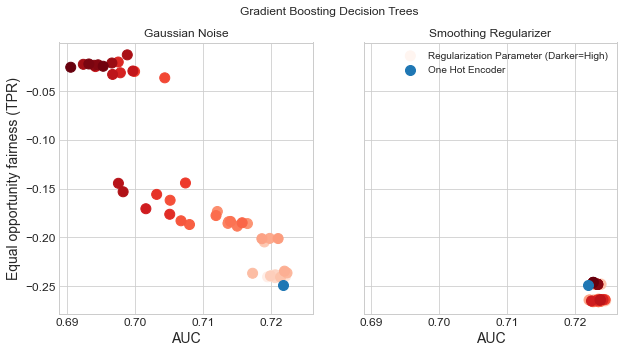

In [34]:

fig, (ax1, ax2) = plt.subplots(1, 2,sharex=True,sharey=True)
fig.suptitle('Gradient Boosting Decision Trees')
#for ax in (ax1, ax2):
#    ax.set_xlim([XMIN, XMAX])
#    ax.set_ylim([YMIN, YMAX])
    
ax1.set_title('Gaussian Noise')
ax1.set(xlabel='AUC', ylabel='Equal opportunity fairness (TPR)')
ax1.scatter(
    gaus["auc_tot"].values,
    gaus["fairness_metric"].values,
    s=100,
    c=gaus.index.values,
    cmap="Reds",
    label="Regularization Parameter (Darker=High)"
)
ax1.scatter(
    y=one_hot.fairness_metric, x=one_hot.auc_tot, s=100, label="One Hot Encoder"
)

ax2.set_title('Smoothing Regularizer')
ax2.set(xlabel='AUC')
ax2.scatter(
    smooth["auc_tot"].values,
    smooth["fairness_metric"].values,
    s=100,
    c=smooth.index.values,
    cmap="Reds",
    label="Regularization Parameter (Darker=High)"
)
ax2.scatter(
    y=one_hot.fairness_metric, x=one_hot.auc_tot, s=100, label="One Hot Encoder"
)
ax2.legend()
plt.savefig('images/GBDTEnc.eps',format='eps')
fig.show()

# Time evaluation

## Logistic

In [35]:
fast = Pipeline([('enc',MEstimateEncoder()),('model',LogisticRegression())])

In [36]:
%%timeit -n 10
fast.fit(X,y)


626 ms ± 18.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [37]:
fast = Pipeline([('enc',CatBoostEncoder()),('model',LogisticRegression())])


In [38]:
%%timeit -n 10
fast.fit(X,y)

689 ms ± 56.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [39]:
fast = Pipeline([('enc',OneHotEncoder()),('model',LogisticRegression())])


In [40]:
%%timeit -n 10
fast.fit(X,y)

1.4 s ± 232 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [41]:
fast = Pipeline([('enc',LeaveOneOutEncoder()),('model',LogisticRegression())])

In [42]:
%%timeit -n 10
fast.fit(X,y)

684 ms ± 69.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Decision Tree

In [43]:
fast = Pipeline([('enc',MEstimateEncoder()),('model',DecisionTreeClassifier())])

In [44]:
%%timeit -n 10
fast.fit(X,y)


259 ms ± 1.77 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [45]:
fast = Pipeline([('enc',CatBoostEncoder()),('model',DecisionTreeClassifier())])


In [46]:
%%timeit -n 10
fast.fit(X,y)

1.29 s ± 124 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [47]:
fast = Pipeline([('enc',OneHotEncoder()),('model',DecisionTreeClassifier())])


In [48]:
%%timeit -n 10
fast.fit(X,y)

659 ms ± 45.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [49]:
fast = Pipeline([('enc',LeaveOneOutEncoder()),('model',DecisionTreeClassifier())])

In [50]:
%%timeit -n 10
fast.fit(X,y)

282 ms ± 2.09 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## GBDT

In [51]:
fast = Pipeline([('enc',MEstimateEncoder()),('model',GradientBoostingClassifier())])

In [52]:
%%timeit -n 10
fast.fit(X,y)


2.31 s ± 89.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [53]:
fast = Pipeline([('enc',CatBoostEncoder()),('model',GradientBoostingClassifier())])


In [54]:
%%timeit -n 10
fast.fit(X,y)

14.6 s ± 857 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [55]:
fast = Pipeline([('enc',OneHotEncoder()),('model',GradientBoostingClassifier())])


In [56]:
%%timeit -n 10
fast.fit(X,y)

5.9 s ± 162 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [57]:
fast = Pipeline([('enc',LeaveOneOutEncoder()),('model',GradientBoostingClassifier())])


In [58]:
%%timeit -n 10
fast.fit(X,y)

1.58 s ± 16 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
